In [1]:
# NO NEED TO RUN THIS EVERY TIME

# install kaggle if you do not have it using pip or pip3
!pip3 install kaggle

# 1. Login to kaggle
# 2. Go to Settings -> Account -> API
# 3. Click Create New Token
# 4. Run the command below

# might have to change the file locations
# first location is the path of the downloaded token
# second location is the path of kaggle after you install kaggle
!cp ./kaggle.json ~/.kaggle

# this just hides the token from other users just to be safe
# path is the same as the second location
!chmod 600 ~/.kaggle/kaggle.json

cp: ./kaggle.json: No such file or directory


In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision as tv
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms.functional as tf

In [2]:
# the name of the folder that the data will be downloaded into
data_path = ['./ASL_Dataset1',
             './ASL_Dataset2',
             './ASL_Dataset3']

# the name of the dataset specified in kaggle
dataset_name = ['kapillondhe/american-sign-language',
                'debashishsau/aslamerican-sign-language-aplhabet-dataset',
                'grassknoted/asl-alphabet']

In [3]:
# use the kaggle api to download the files
# might take a while
try:
    # checks if kaggle.json exists
    from kaggle.api.kaggle_api_extended import KaggleApi

    # authenticate the api
    api = KaggleApi()
    api.authenticate()

    # check if the datapath length matches that of the dataset
    if len(data_path) == len(dataset_name):
        for index, path in enumerate(data_path):
            # if the file already exists
            if os.path.exists(path):
                print("Dataset {} found in {}.".format(dataset_name[index], path))
                continue

            print("Downloading {} dataset...".format(dataset_name[index]))
            
            # create the directory
            os.makedirs(path)
            # download the dataset
            api.dataset_download_files(dataset_name[index], path=path, unzip=True)

            print("Finished downloading {}.".format(dataset_name[index]))
    else:
        print("Error. Check data path or data set.")
except KeyboardInterrupt:
    print("Download failed.")
except:
    print("No Kaggle API. Download the token by following the steps above.")

Dataset kapillondhe/american-sign-language found in ./ASL_Dataset1.
Dataset debashishsau/aslamerican-sign-language-aplhabet-dataset found in ./ASL_Dataset2.
Dataset grassknoted/asl-alphabet found in ./ASL_Dataset3.


In [4]:
# random seed
seed_num = 1

torch.manual_seed(seed_num)
random.seed(seed_num)

In [5]:
# letters in the dataset
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 
            'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Space', 'Nothing', 'Del']

extra_path = ['/Train/', '/asl_alphabet_train/asl_alphabet_train/', '/asl_alphabet_train/']

# index of each letter
# ex. {'A' : 0, 'B': 1, ...}
letter_index = {}
# populate letter_index
for index, letter in enumerate(letters):
    letter_index[letter] = index

In [58]:
# if cut is true then reduce the data set for each letter to num_data for each data path
cut = True
num_data = 500

test_val_split = 0.8

if cut:
    print("Loading {} images for training and {} images for validation.".format(int(num_data * test_val_split), num_data - int(num_data * test_val_split)))
else:
    print("Loading {}% of images for training and {}% of images.".format(int(test_val_split * 100), 100 - int(test_val_split * 100)))

Loading 400 images for training and 100 images for validation.


In [61]:
print("Loading Images...\n")

# training and validation data
training_data = []
validation_data = []
test_data = []

prev_training = 0
prev_validation = 0
prev_test = 0

target_size = (224, 224)

# loop through all the directories
for path_index, path in enumerate(data_path):
    # all files in the data_path
    files_in_data_path = os.listdir(path)


    # loop through the letters
    for letter in letters:
        try:
            # append the path of each letter into letter_path
            letter_path = list(os.listdir(path + extra_path[path_index] + letter))
            random.shuffle(letter_path)
        except:
            # no letter in the data set
            print("No {} in {}.".format(letter, path))
            continue

        len_data = num_data if cut else len(letter_path)

        # loop through each path in letter_path
        for index, image_path in enumerate(letter_path):
            if cut and index >= num_data:
                break
            # append the image of each letter into image and its label
            full_path = path + extra_path[path_index] + letter + '/' + image_path

            # split between test and validation data
            if int(len_data * 0.7) > index:
                training_data.append((tf.to_tensor(Image.open(full_path).resize(target_size)), letter_index[letter]))
            elif int(len_data * 0.85) > index:
                validation_data.append((tf.to_tensor(Image.open(full_path).resize(target_size)), letter_index[letter]))
            else:
                test_data.append((tf.to_tensor(Image.open(full_path).resize(target_size)), letter_index[letter]))
    
    # print statement for how many images per letter
    print("------------------------------------------------------")
    print("Loaded {} training set data from {}.".format(len(training_data) - prev_training, path))
    print("Loaded {} validation set data from {}.".format(len(validation_data) - prev_validation, path))

    prev_training = len(training_data)
    prev_validation = len(validation_data)
    prev_test = len(test_data)

random.shuffle(training_data)
random.shuffle(validation_data)
random.shuffle(test_data)

print("------------------------------------------------------")
print("Loaded {} training set data in total.".format(len(training_data)))
print("Loaded {} validation set data in total".format(len(validation_data)))
print("Loaded {} test set data in total".format(len(test_data)))

Loading Images...

No Del in ./ASL_Dataset1.
------------------------------------------------------
Loaded 9800 training set data from ./ASL_Dataset1.
Loaded 2100 validation set data from ./ASL_Dataset1.
------------------------------------------------------
Loaded 10150 training set data from ./ASL_Dataset2.
Loaded 2175 validation set data from ./ASL_Dataset2.
------------------------------------------------------
Loaded 10150 training set data from ./ASL_Dataset3.
Loaded 2175 validation set data from ./ASL_Dataset3.
------------------------------------------------------
Loaded 30100 training set data in total.
Loaded 6450 validation set data in total
Loaded 6450 test set data in total


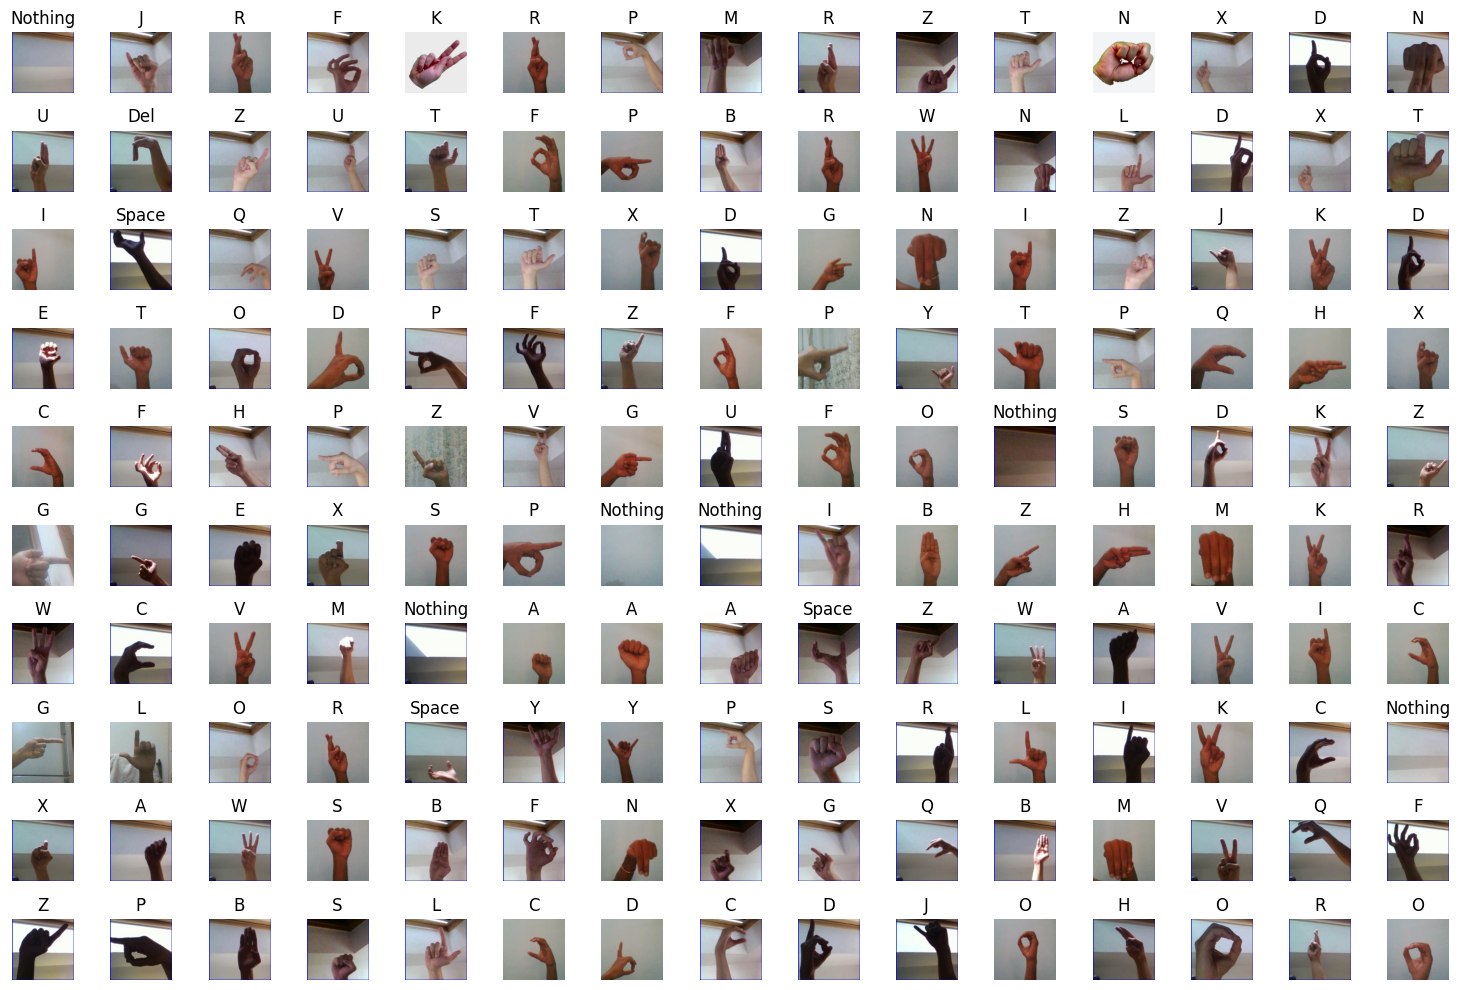

In [48]:
# number of rows and columns
row = 10
col = 15

plt.figure(figsize=(col, row))
for index in range(len(training_data)):
    # get the image and label of the data set
    image = tv.transforms.ToPILImage()(training_data[index][0])
    label = list(letter_index.keys())[list(letter_index.values()).index(training_data[index][1])]

    # reached end of row * col
    if index >= row * col:
      break

    # plot the letters
    plt.subplot(row, col, index + 1)
    plt.axis('off')
    plt.title(label)
    plt.tight_layout()
    plt.imshow(image)

In [19]:
alexnet = tv.models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

In [62]:
batch_size = 256
num_workers = 0

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

images, labels = next(iter(train_loader))

In [22]:
features = alexnet.features(images)

In [23]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
out_features = 512

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(in_features=256*6*6, out_features=out_features)
        self.fc2 = nn.Linear(in_features=out_features, out_features=len(letters))
    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [55]:
# get the accuracy of the model prediction and the actual value
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = validation_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        # use cuda
        if torch.backends.mps.is_built():
            imgs = imgs.to("mps")
            labels = labels.to("mps")

        # get the output using alex net
        output = model(ALNC(imgs))

        # select index with maximum prediction
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [26]:
# train the model using alex net
def train(model, data, batch_size, num_epochs, learning_rate, momentum, print_training_accuracy=True, print_validation_accuracy=False, print_training_plot=True, print_validation_plot=False):
    # use cross entropy loss function and SGD with momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []


    n = 0
    for epoch in range(num_epochs):
        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0
        print("epoch: {}".format(epoch))

        for imgs, labels in iter(train_loader):
            # use cuda
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            
            # calculate loss
            out = model(ALNC(imgs))
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # find the loss and accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)
            iters.append(n)
            losses.append(float(loss) / batch_size)
            val_acc.append(get_accuracy(model, train=False))
            n += 1
            mini_b += 1
        
        # print the accuracy
        if print_training_accuracy:
            print("Training Accuracy = {}".format(train_acc[-1]))
        if print_validation_accuracy:
            print("Validation Accuracy = {}".format(val_acc[-1]))

    if not(print_training_plot == False and print_validation_plot == False):
        # plot the loss curve
        plt.title("Training Curve")
        plt.plot(iters, losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        # plot the training and validation curve
        plt.title("Training Curve")
        if print_training_plot:
            plt.plot(iters, train_acc, label="Training")
        if print_validation_plot:
            plt.plot(iters, val_acc, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("Validation Accuracy")
        plt.legend(loc='best')
        plt.show()

    # print the final accuracies
    train_acc.append(get_accuracy(model, train=True))
    if print_training_accuracy:
        print("Final Training Accuracy: {}".format(train_acc[-1]))
    if print_validation_accuracy:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))
    


epoch: 0
Training Accuracy = 0.45454545454545453
Validation Accuracy = 0.49534883720930234
epoch: 1
Training Accuracy = 0.7045454545454546
Validation Accuracy = 0.7356589147286822
epoch: 2
Training Accuracy = 0.8181818181818182
Validation Accuracy = 0.7875968992248062
epoch: 3
Training Accuracy = 0.8181818181818182
Validation Accuracy = 0.8248062015503876
epoch: 4
Training Accuracy = 0.9166666666666666
Validation Accuracy = 0.8550387596899225
epoch: 5
Training Accuracy = 0.9545454545454546
Validation Accuracy = 0.8728682170542635
epoch: 6
Training Accuracy = 0.9545454545454546
Validation Accuracy = 0.8798449612403101
epoch: 7
Training Accuracy = 0.946969696969697
Validation Accuracy = 0.8713178294573644
epoch: 8
Training Accuracy = 0.946969696969697
Validation Accuracy = 0.8992248062015504
epoch: 9
Training Accuracy = 0.9924242424242424
Validation Accuracy = 0.8945736434108527
epoch: 10
Training Accuracy = 0.946969696969697
Validation Accuracy = 0.9038759689922481
epoch: 11
Training Ac

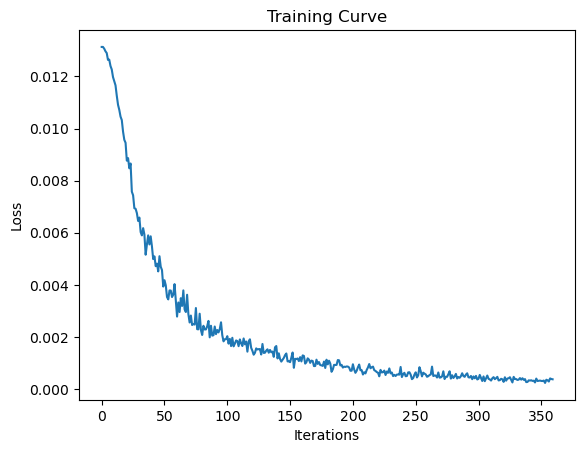

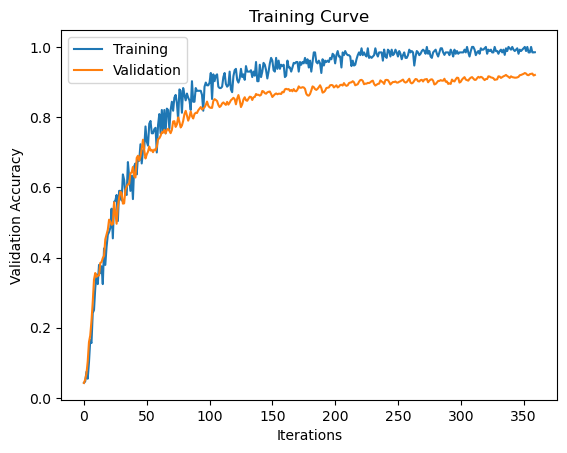

Final Training Accuracy: 0.9943521594684386
Final Validation Accuracy: 0.92015503875969


In [27]:
# use alex net 
model = ANN()
ALNC = alexnet.features

# hyperparameters
num_epochs = 15
learning_rate = 0.01
momentum = 0.9

if torch.backends.mps.is_built():
  model.to("mps")
  ALNC.to("mps")

train(model, [], batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum,
print_training_accuracy=True, print_validation_accuracy=True, print_training_plot=True, print_validation_plot=True)

In [ ]:
torch.save(model, "./alexnet_model.pth")

In [101]:
# get the accuracy of the model prediction and the actual value
corr = np.zeros(29)
act = np.zeros(29)
from sklearn.metrics import confusion_matrix
def get_test_accuracy(model):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for imgs, labels in test_loader:

        # use cuda
        if torch.backends.mps.is_built():
            imgs = imgs.to("mps")
            labels = labels.to("mps")

        # get the output using alex net
        output = model(ALNC(imgs))

        # select index with maximum prediction
        pred = output.max(1, keepdim=True)[1]
        correct_indices = pred.eq(labels.view_as(pred))
        
        # increment results for correct predictions
        for idx, correct_pred in enumerate(correct_indices):
            if correct_pred.item():
                corr[labels[idx].item()] += 1
            act[labels[idx].item()] += 1
            all_preds.append(pred[idx].item())
            all_labels.append(labels[idx].item())
            
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return corr, act, cm_percentage

In [102]:
target_size = (224, 224)
ALNC = alexnet.features

a, b, cm = get_test_accuracy(model)

In [79]:
a

array([222., 236., 233., 231., 227., 232., 238., 233., 222., 220., 234.,
       242., 236., 231., 236., 235., 243., 215., 204., 219., 230., 211.,
       242., 222., 216., 233., 247., 249., 155.])

In [80]:
b

array([254., 253., 248., 246., 257., 253., 256., 256., 254., 246., 249.,
       250., 253., 254., 258., 249., 251., 246., 251., 257., 255., 254.,
       246., 247., 254., 245., 255., 249., 171.])

In [85]:
for i in range(29):
    print("Accuracy of {}: {:.2f}%".format(letters[i], a[i]/b[i] * 100))

Accuracy of A: 87.40%
Accuracy of B: 93.28%
Accuracy of C: 93.95%
Accuracy of D: 93.90%
Accuracy of E: 88.33%
Accuracy of F: 91.70%
Accuracy of G: 92.97%
Accuracy of H: 91.02%
Accuracy of I: 87.40%
Accuracy of J: 89.43%
Accuracy of K: 93.98%
Accuracy of L: 96.80%
Accuracy of M: 93.28%
Accuracy of N: 90.94%
Accuracy of O: 91.47%
Accuracy of P: 94.38%
Accuracy of Q: 96.81%
Accuracy of R: 87.40%
Accuracy of S: 81.27%
Accuracy of T: 85.21%
Accuracy of U: 90.20%
Accuracy of V: 83.07%
Accuracy of W: 98.37%
Accuracy of X: 89.88%
Accuracy of Y: 85.04%
Accuracy of Z: 95.10%
Accuracy of Space: 96.86%
Accuracy of Nothing: 100.00%
Accuracy of Del: 90.64%


In [123]:
m = 0.0844
max = 0
idx = 0
jdx = 0
for i in range(29):
    for j in range(29):
        if cm[i][j] == 0.08444444444444445:
            continue
        if cm[i][j] == 0.07111111111111111:
            continue
        if i != j and max < cm[i][j]:
            max = cm[i][j]
            idx = i
            jdx = j


print("{} and {} are being confused {:.2f}% of the time.".format(letters[idx], letters[jdx], max * 100))



Y and T are being confused 5.33% of the time.
